## Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

In [2]:
df=pd.read_csv('climate.csv', index_col="DATE", infer_datetime_format=True, parse_dates=True).drop(['STATION','SNWD'],axis=1)

In [3]:
df.head()

,PRCP,TAVG,TMAX,TMIN
DATE,,,,
2000-01-01,0.04,48,50.0,45.0
2000-01-02,0.00,46,50.0,NaN
2000-01-03,0.00,45,47.0,42.0
2000-01-04,0.00,47,NaN,NaN
2000-01-05,0.06,47,51.0,NaN


**Preprocessing data**

In [4]:
df=df.astype(float)
start_date = df.index.min()
end_date = df.index.max()
full_index = pd.date_range(start=start_date, end=end_date, freq='D')
df = df.reindex(full_index)
df.fillna(method='ffill', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')

In [5]:
df.head()

,PRCP,TAVG,TMAX,TMIN
2000-01-01,0.04,48.0,50.0,45.0
2000-01-02,0.00,46.0,50.0,45.0
2000-01-03,0.00,45.0,47.0,42.0
2000-01-04,0.00,47.0,47.0,42.0
2000-01-05,0.06,47.0,51.0,42.0


## Linear time series

**Plot**

<AxesSubplot:title={'center':'Precipitations'}>

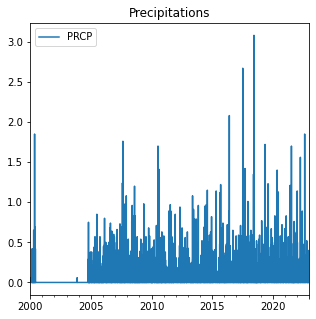

In [6]:
df[["PRCP"]].plot(figsize=(5,5), title="Precipitations")

Starting from 2005, we can see that the precipitations keep a steady value with a lot of extreme values , while between 2000 and 2005, there is nearly no precipitations.
In the short term, the data can be considered moderatly volatile.

In [7]:
print('Average precipitations : ', df.loc['2005-01-01': ,"PRCP"].mean())
print('STD precipitations : ', df.loc['2005-01-01': ,"PRCP"].std())

Average precipitations :  0.06518557955582599
STD precipitations :  0.16106849012460858


<AxesSubplot:title={'center':'Air temperature'}>

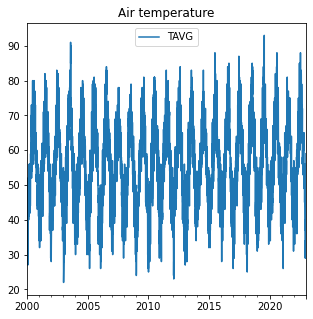

In [8]:
df[["TAVG"]].plot(figsize=(5,5), title="Air temperature")

There is a clear seasonality in the temperature data.
Let's zoom in to see if there is a lot of small fluctuations.

<AxesSubplot:title={'center':'Air temperature'}>

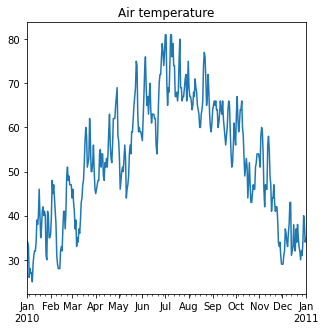

In [9]:
df.loc['2010-01-01':'2011-01-01' ,"TAVG"].plot(figsize=(5,5), title="Air temperature")

In the short term, data seems to be volatile considering the numerous small fluctuations in the plot.

**Hodrick-Prescott Filter**

In [10]:
prcp_noise, prcp_trend = sm.tsa.filters.hpfilter(df['PRCP'])

In [11]:
hp_prcp=pd.DataFrame(df['PRCP']).copy()
hp_prcp['noise']=prcp_noise
hp_prcp['trend']=prcp_trend

<AxesSubplot:title={'center':'Trend of precipitations'}>

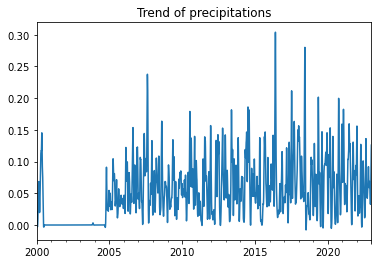

In [12]:
prcp_trend.plot(title="Trend of precipitations")

<AxesSubplot:title={'center':'Value vs. Trend '}>

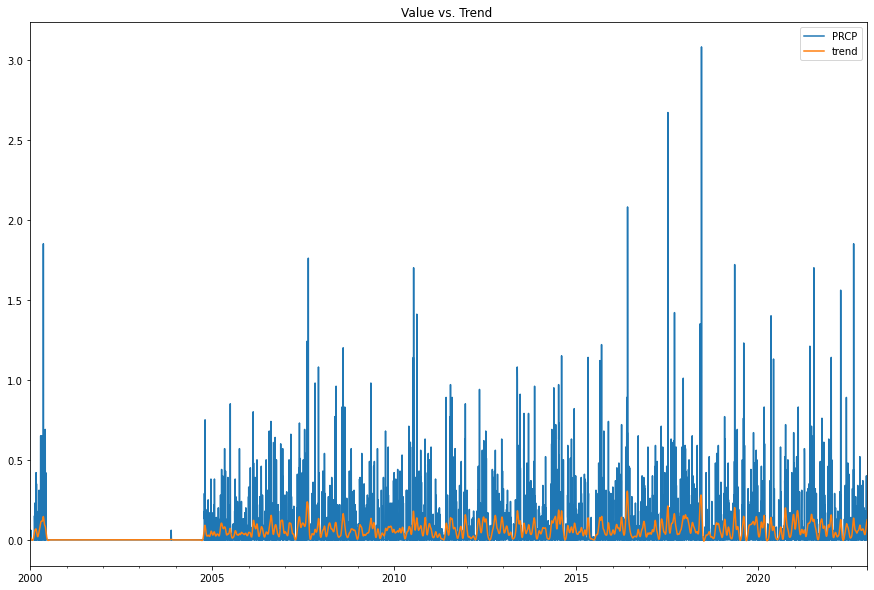

In [13]:
hp_prcp[["PRCP", "trend"]].plot(figsize=(15,10), title="Value vs. Trend ")

The Hodrick-Prescott Filter deletes extreme fluctuations.   
In the long term, the trend plot allows us to confirm that there is a general constancy in the value of precipitations.  
In the short term, we can still see some fluctuations that may correspond to monthly changes.

In [14]:
tavg_noise, tavg_trend = sm.tsa.filters.hpfilter(df['TAVG'])

In [15]:
hp_tavg=pd.DataFrame(df['TAVG']).copy()
hp_tavg['noise']=tavg_noise
hp_tavg['trend']=tavg_trend

<AxesSubplot:title={'center':'Trend of air temperature'}>

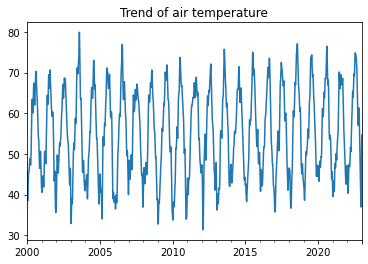

In [16]:
tavg_trend.plot(title="Trend of air temperature")

<AxesSubplot:title={'center':'Value vs. Trend '}>

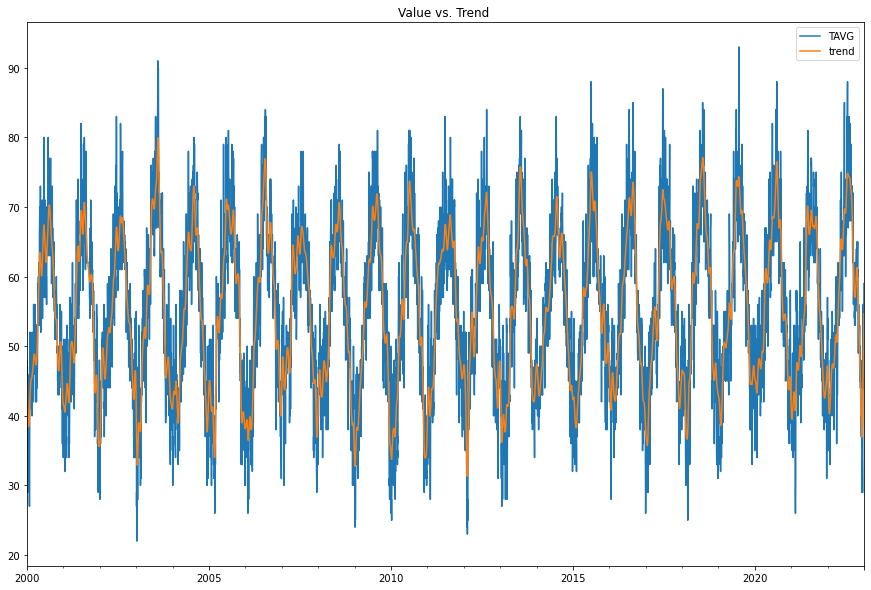

In [17]:
hp_tavg[["TAVG", "trend"]].plot(figsize=(15,10), title="Value vs. Trend ")

The trend helps to confirm that there is a clear yearly seasonality.

## Seasonality

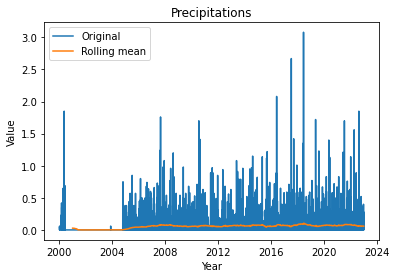

In [18]:
rolling_mean = df['PRCP'].rolling(window=365).mean()

plt.plot(df.index,df['PRCP'], label='Original')
plt.plot(rolling_mean.index, rolling_mean, label='Rolling mean')
plt.legend(loc='best')
plt.title('Precipitations')
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

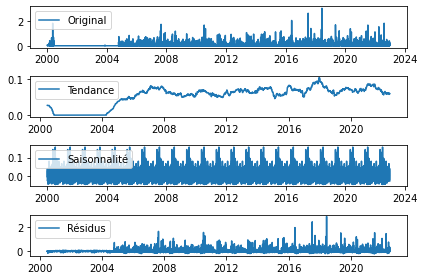

In [19]:
decomposition = seasonal_decompose(df['PRCP'], model='additive', period=365)

seasonal = decomposition.seasonal
trend = decomposition.trend
residual = decomposition.resid

plt.subplot(411)
plt.plot(df['PRCP'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Saisonnalité')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Résidus')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

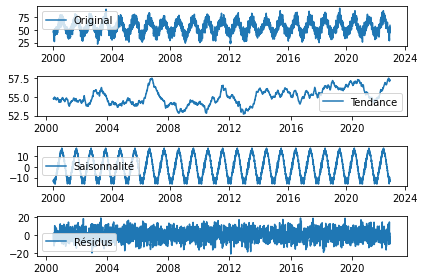

In [20]:
decomposition = seasonal_decompose(df['TAVG'], model='additive', period=365)

seasonal = decomposition.seasonal
trend = decomposition.trend
residual = decomposition.resid


plt.subplot(411)
plt.plot(df['TAVG'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Saisonnalité')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Résidus')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Stationarity

**ADF**

In [38]:
adf_p_value = adfuller(df['TAVG'], autolag='AIC')[1]
print('p-value:', adf_p_value)

p-value: 7.205973788507242e-07


The p-value is <<0.05 . The data is stationnary.  
Let's use a different test to be sure.

**KPSS**

In [39]:
kpss_p_value = kpss(df['TAVG'])[1]
print(f"P-value: {kpss_p_value}")

P-value: 0.1


C:\Users\idris\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Again, KPSS test shows that data is stationary.

**PACF and ACF**

C:\Users\idris\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


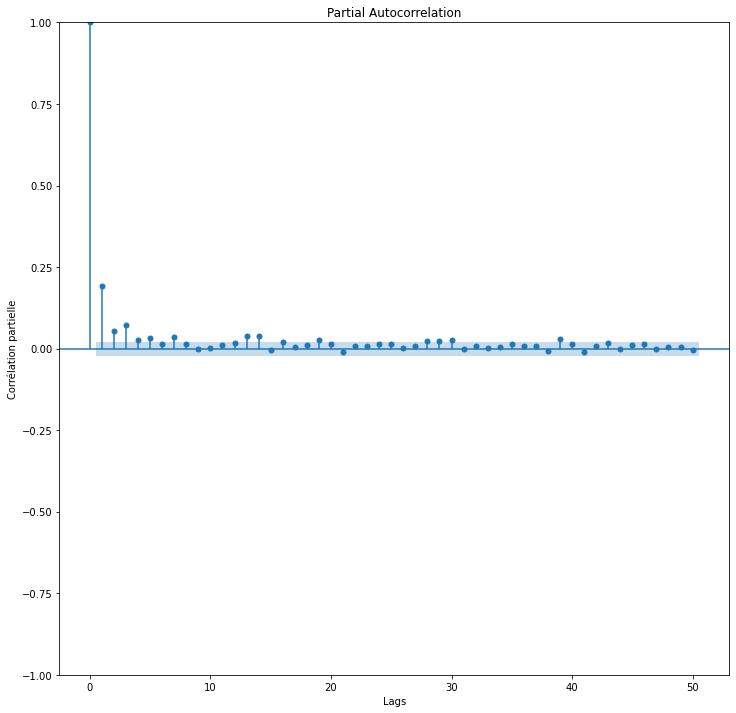

In [30]:
fig, ax = plt.subplots(figsize=(12,12))
plot_pacf(df['PRCP'], lags=50, ax=ax)
plt.xlabel('Lags')
plt.ylabel('Corrélation partielle')
plt.show()

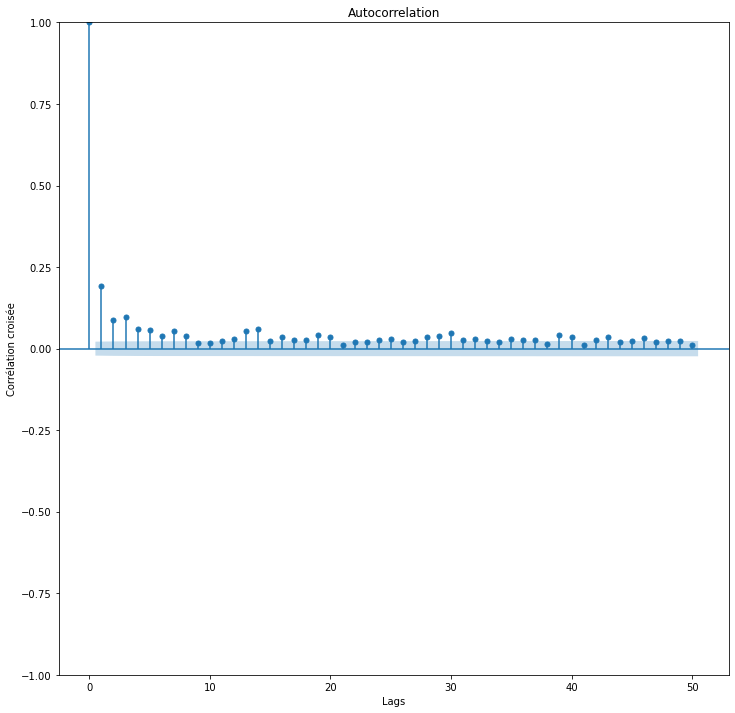

In [31]:
fig, ax = plt.subplots(figsize=(12,12))
plot_acf(df['PRCP'], lags=50, ax=ax)
plt.xlabel('Lags')
plt.ylabel('Corrélation croisée')
plt.show()

According to these plots, we take p=q=1

## Modèle ENCORE A CHOISIR

In [33]:
min_bic, best_p, best_q = np.inf, 1, 1
for p in range(5):
    for q in range(5):
        model = sm.tsa.ARIMA(df['PRCP'], order=(p,0,q))
        results = model.fit()
        bic = results.bic
        if bic < min_bic:
            min_bic = bic
            best_p, best_q = p, q


C:\Users\idris\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\idris\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\idris\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\idris\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\idris\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: N

In [34]:
print(best_q)

1


In [36]:
model = sm.tsa.ARIMA(df['PRCP'], order=(best_p,0,best_q))
results = model.fit()
print(results.summary())

C:\Users\idris\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   PRCP   No. Observations:                 8401
Model:                 ARIMA(4, 0, 1)   Log Likelihood                4405.916
Date:                Tue, 07 Mar 2023   AIC                          -8797.832
Time:                        12:50:40   BIC                          -8748.579
Sample:                    01-01-2000   HQIC                         -8781.015
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0505      0.013      3.841      0.000       0.025       0.076
ar.L1          1.1699      0.006    182.838      0.000       1.157       1.182
ar.L2         -0.1418      0.011    -12.844      0.0

<AxesSubplot:title={'center':'50 Day Futures Price Forecast'}>

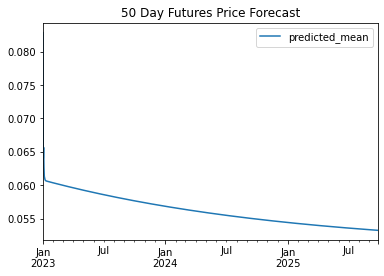

In [37]:
pd.DataFrame(results.forecast(steps=1000)).plot(title="50 Day Futures Price Forecast")

## GARCH processes